# VAR model Implementation 

In [2]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

## This is an "Time-series data" which mainly focuses on the "Wage Growth and the Inflation Process"
### This dataset has has the following 8 quarterly time series:
1. rgnp  : Real GNP.
2. pgnp  : Potential real GNP.
3. ulc   : Unit labor cost.
4. gdfco : Fixed weight deflator for personal consumption expenditure excluding food and energy.
5. gdf   : Fixed weight GNP deflator.
6. gdfim : Fixed weight import deflator.
7. gdfcf : Fixed weight deflator for food in personal consumption expenditure.
8. gdfce : Fixed weight deflator for energy in personal consumption expenditure.


In [3]:
filepath = 'https://raw.githubusercontent.com/selva86/datasets/master/Raotbl6.csv'
macro_data = pd.read_csv(filepath, parse_dates=['date'], index_col='date')
print(macro_data.shape)  # (123, 8)
macro_data.head()

(123, 8)


,rgnp,pgnp,ulc,gdfco,gdf,gdfim,gdfcf,gdfce
date,,,,,,,,
1959-01-01,1606.4,1608.3,47.5,36.9,37.4,26.9,32.3,23.1
1959-04-01,1637.0,1622.2,47.5,37.4,37.5,27.0,32.2,23.4
1959-07-01,1629.5,1636.2,48.7,37.6,37.6,27.1,32.4,23.4
1959-10-01,1643.4,1650.3,48.8,37.7,37.8,27.1,32.5,23.8
1960-01-01,1671.6,1664.6,49.1,37.8,37.8,27.2,32.4,23.8


#### This code creates a grid of 8 subplots (4 rows by 2 columns) and plots each of the time series in the macro_data DataFrame in a separate subplot. Each subplot is titled with the name of the corresponding time series, and the x and y ticks are hidden for a cleaner look. The tight_layout function ensures that the subplots are nicely spaced within the figure.



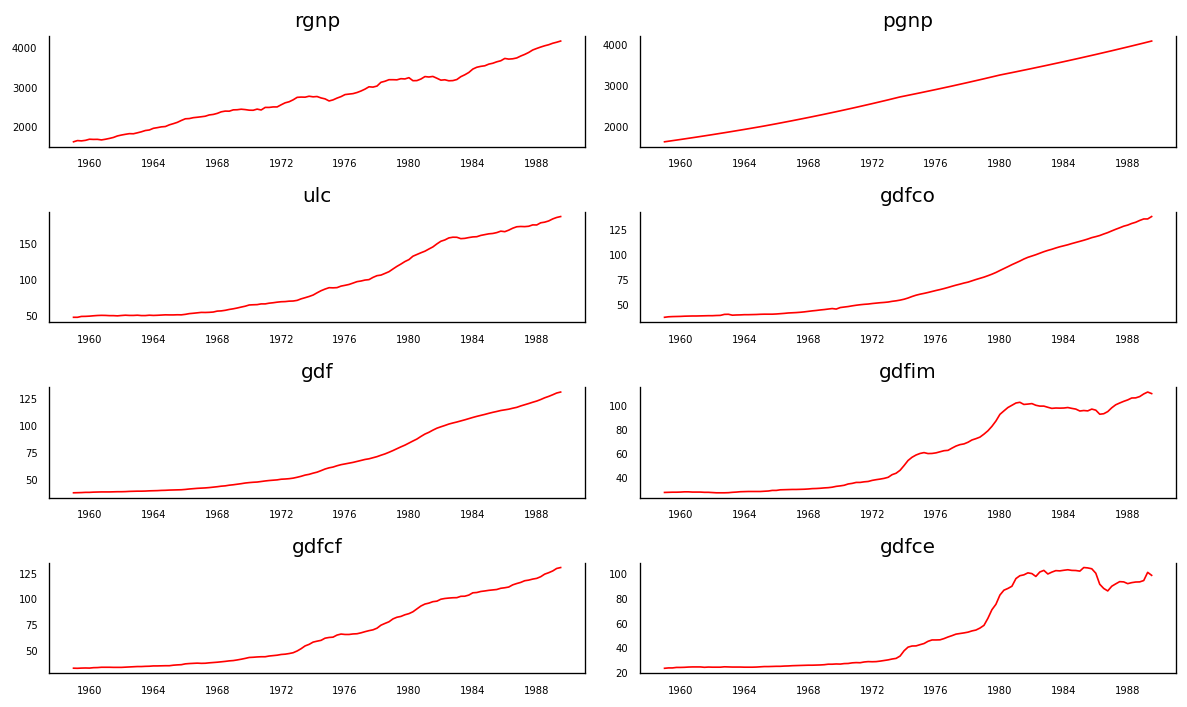

In [4]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = macro_data[macro_data.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(macro_data.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

#### The code performs a seasonal decomposition of the 'rgnp' (Real Gross National Product) time series from the macro_data DataFrame. This process involves breaking down the time series into three distinct components: trend, seasonality, and residuals. The decomposition is visualized through plots to aid in understanding the underlying patterns in the data.

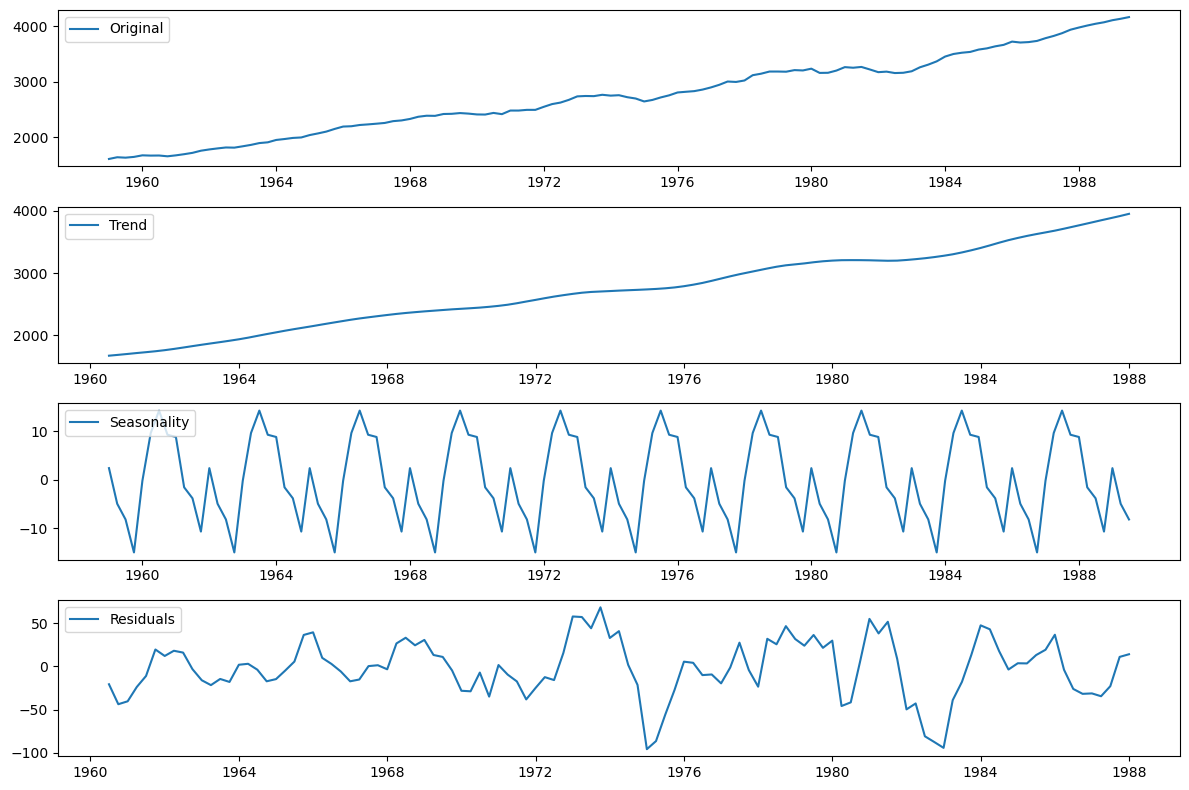

Original Series:
date
1959-01-01    1606.4
1959-04-01    1637.0
1959-07-01    1629.5
1959-10-01    1643.4
1960-01-01    1671.6
1960-04-01    1666.8
1960-07-01    1668.4
1960-10-01    1654.1
1961-01-01    1671.3
1961-04-01    1692.1
Name: rgnp, dtype: float64

Trend Component:
date
1959-01-01            NaN
1959-04-01            NaN
1959-07-01            NaN
1959-10-01            NaN
1960-01-01            NaN
1960-04-01            NaN
1960-07-01    1674.795833
1960-10-01    1688.583333
1961-01-01    1702.875000
1961-04-01    1717.470833
Name: trend, dtype: float64

Seasonal Component:
date
1959-01-01     2.400397
1959-04-01    -4.956547
1959-07-01    -8.194510
1959-10-01   -15.004232
1960-01-01    -0.208862
1960-04-01     9.649934
1960-07-01    14.280027
1960-10-01     9.293777
1961-01-01     8.830027
1961-04-01    -1.564417
Name: seasonal, dtype: float64

Residual Component:
date
1959-01-01          NaN
1959-04-01          NaN
1959-07-01          NaN
1959-10-01          NaN
1960-01-01 

In [5]:
# Choose a time series to decompose, here 'rgnp'
series = macro_data['rgnp']

# Decompose the time series using seasonal_decompose
decomposition = seasonal_decompose(series, model='additive', period=12)  # assuming monthly data, so period=12

# Extract the components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(series, label='Original')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

print("Original Series:")
print(series.head(10))
print("\nTrend Component:")
print(trend.head(10))
print("\nSeasonal Component:")
print(seasonal.head(10))
print("\nResidual Component:")
print(residual.head(10))

- The code first calculates the first differences of 'rgnp' and 'ulc' series to make them stationary.
- It then performs the Augmented Dickey Fuller Test (ADF) test to check for stationarity, printing the results.
- Identification of an AR model is often best done with the PACF.
  - For an AR model, the theoretical PACF "shuts off" past the order of the model. The phrase "shuts off" means that in theory the partial autocorrelations are equal to 0 beyond that point. Put another way, the number of non-zero partial autocorrelations gives the order of the AR model. By the "order of the model" we mean the most extreme lag of x that is used as a predictor.
- Identification of an MA model is often best done with the ACF rather than the PACF.
  - For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner. A clearer pattern for an MA model is in the ACF. The ACF will have non-zero autocorrelations only at lags involved in the model.
- These steps are crucial in identifying the appropriate parameters for modeling and ensuring the time series data is suitable for modeling.

realgdp
ADF Statistic: -5.427594381007334
p-value: 2.9633019848468996e-06

---------------------

realcons
ADF Statistic: -3.5760804731509115
p-value: 0.006235131830238156


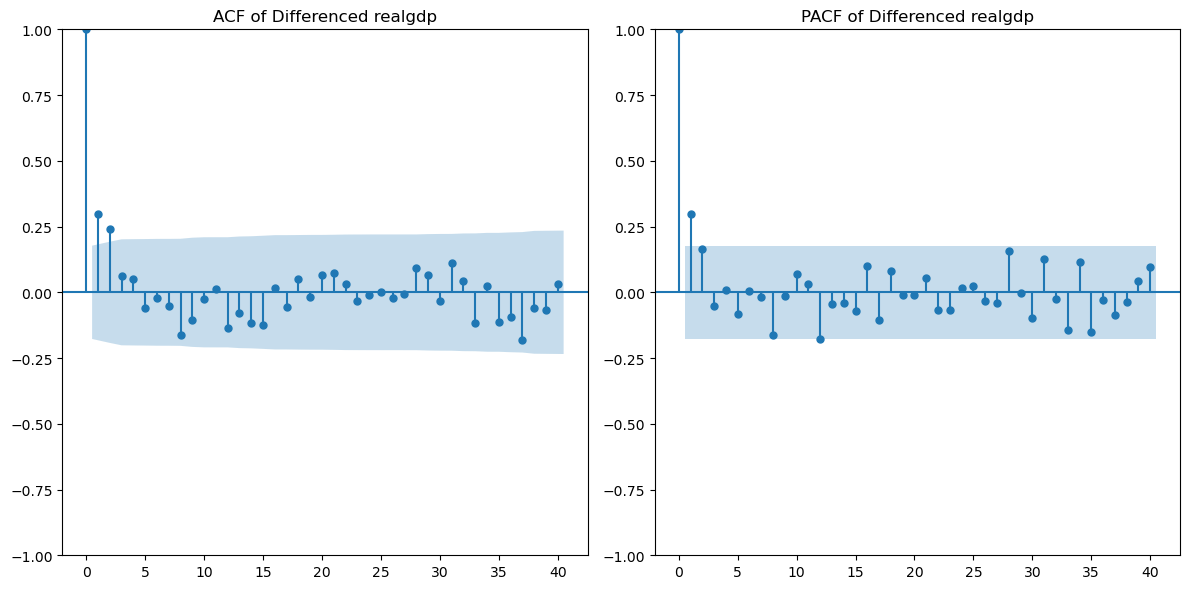

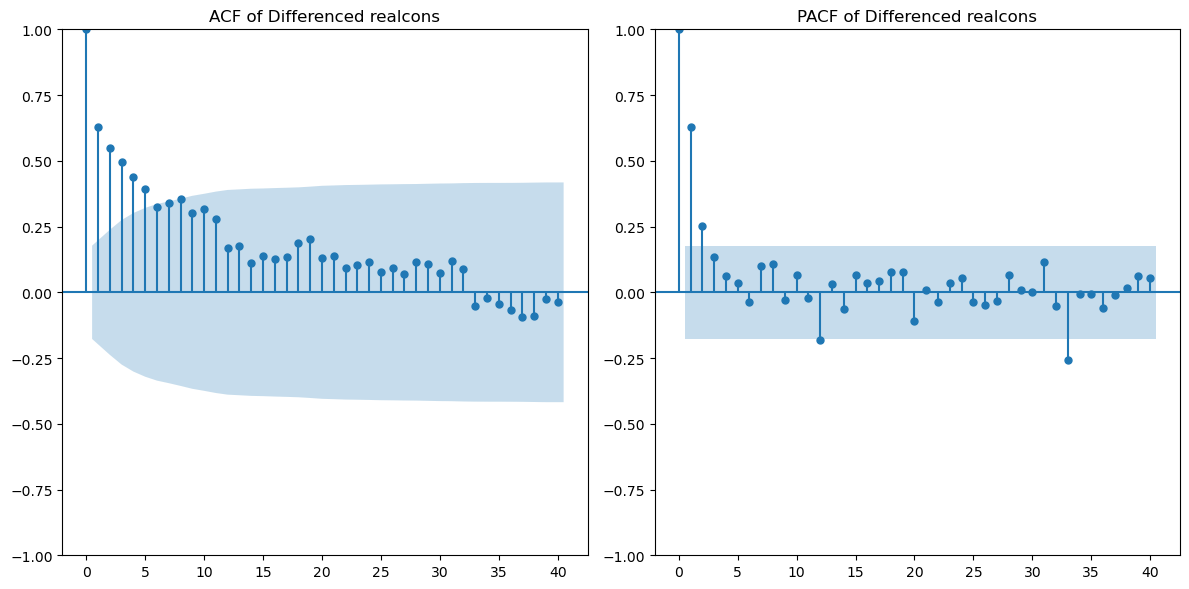

In [6]:
diff_rgnp = macro_data['rgnp'].diff().dropna()
diff_ulc = macro_data['ulc'].diff().dropna()

ad_fuller_result_1 = adfuller(macro_data['rgnp'].diff()[1:])

print('realgdp')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(macro_data['ulc'].diff()[1:])

print('realcons')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

plt.figure(figsize=(12, 6))

plt.subplot(121)
plot_acf(diff_rgnp, lags=40, ax=plt.gca())
plt.title('ACF of Differenced realgdp')

plt.subplot(122)
plot_pacf(diff_rgnp, lags=40, ax=plt.gca())
plt.title('PACF of Differenced realgdp')

plt.tight_layout()
plt.show()

# Plot ACF and PACF for the differenced 'ulc'
plt.figure(figsize=(12, 6))

plt.subplot(121)
plot_acf(diff_ulc, lags=40, ax=plt.gca())
plt.title('ACF of Differenced realcons')

plt.subplot(122)
plot_pacf(diff_ulc, lags=40, ax=plt.gca())
plt.title('PACF of Differenced realcons')

plt.tight_layout()
plt.show()

### The Granger causality test is used to determine whether one time series variable can predict another time series variable. It helps assess the causal relationship between two variables in a time series context

In [7]:
print('rgnp causes ulc?\n')
print('------------------')
granger_1 = grangercausalitytests(macro_data[['ulc', 'rgnp']], 4)

print('\nulc causes rgnp?\n')
print('------------------')
granger_2 = grangercausalitytests(macro_data[['rgnp', 'ulc']], 4)

rgnp causes ulc?

------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=22.3802 , p=0.0000  , df_denom=119, df_num=1
ssr based chi2 test:   chi2=22.9444 , p=0.0000  , df=1
likelihood ratio test: chi2=21.0242 , p=0.0000  , df=1
parameter F test:         F=22.3802 , p=0.0000  , df_denom=119, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.7188  , p=0.0007  , df_denom=116, df_num=2
ssr based chi2 test:   chi2=16.1029 , p=0.0003  , df=2
likelihood ratio test: chi2=15.1179 , p=0.0005  , df=2
parameter F test:         F=7.7188  , p=0.0007  , df_denom=116, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.5231  , p=0.0001  , df_denom=113, df_num=3
ssr based chi2 test:   chi2=23.9675 , p=0.0000  , df=3
likelihood ratio test: chi2=21.8515 , p=0.0001  , df=3
parameter F test:         F=7.5231  , p=0.0001  , df_denom=113, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F

In [8]:
macro_data = macro_data[['ulc','rgnp']]
print(macro_data.shape)

(123, 2)


In [9]:
train_df=macro_data[:-12]
test_df=macro_data[-12:]

In [10]:
print(test_df.shape)

(12, 2)


In [11]:
model = VAR(train_df.diff()[1:])

In [12]:
sorted_order=model.select_order(maxlags=20)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        6.778       6.834       878.3       6.800
1        5.988      6.154*       398.5       6.055
2        5.942       6.220       380.9       6.054
3        5.933       6.322       377.4       6.090
4       5.793*       6.293      328.5*      5.995*
5        5.873       6.484       356.3       6.120
6        5.828       6.550       341.1       6.119
7        5.894       6.727       365.0       6.230
8        5.890       6.835       364.8       6.271
9        5.942       6.998       385.8       6.368
10       5.930       7.097       382.9       6.401
11       5.913       7.191       378.5       6.428
12       5.885       7.274       370.7       6.445
13       5.925       7.424       388.6       6.529
14       5.882       7.493       376.0       6.532
15       5.950       7.672       406.9       6.644
16       5.933       7.766     

In [26]:
var_model = VARMAX(train_df, order=(4,0),enforce_stationarity= True)
fitted_model = var_model.fit(disp=False)
print(fitted_model.summary())

                           Statespace Model Results                           
Dep. Variable:        ['ulc', 'rgnp']   No. Observations:                  111
Model:                         VAR(4)   Log Likelihood              -11838.126
                          + intercept   AIC                          23718.252
Date:                Wed, 12 Jun 2024   BIC                          23775.153
Time:                        14:32:07   HQIC                         23741.335
Sample:                    01-01-1959                                         
                         - 07-01-1986                                         
Covariance Type:                  opg                                         
Ljung-Box (L1) (Q):          37.28, 106.07   Jarque-Bera (JB):         20.79, 13.79
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.56, 0.28   Skew:                      0.64, -0.86
Prob(H) (two-sided):            0.18,

In [18]:
n_forecast = 12
predict = fitted_model.get_prediction(start=len(train_df),end=len(train_df) + n_forecast-1)#start="1989-07-01",end='1999-01-01')

predictions=predict.predicted_mean

In [19]:
predictions.columns=['ulc_predicted','rgnp_predicted']
predictions

,ulc_predicted,rgnp_predicted
1986-10-01,166.253439,3568.041847
1987-01-01,243.924674,3756.147938
1987-04-01,49.309237,3553.712412
1987-07-01,268.080205,3861.821781
1987-10-01,148.321952,3478.843573
1988-01-01,170.118222,3768.065353
1988-04-01,154.538130,3632.843052
1988-07-01,209.636075,3730.781129
1988-10-01,142.893378,3565.276940
1989-01-01,196.887353,3769.915500


In [20]:
test_vs_pred=pd.concat([test_df,predictions],axis=1)

<Axes: >

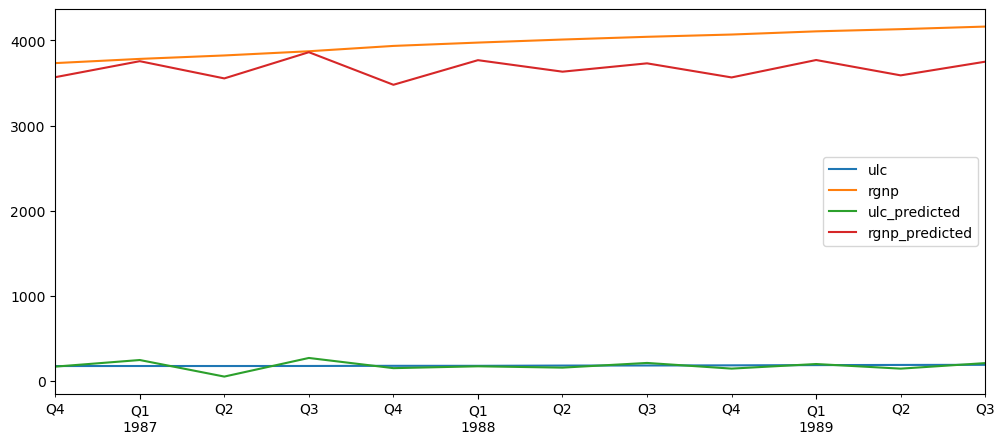

In [21]:
test_vs_pred.plot(figsize=(12,5))

In [22]:
from sklearn.metrics import mean_squared_error
import math 
from statistics import mean

rmse_ulc=math.sqrt(mean_squared_error(predictions['ulc_predicted'],test_df['ulc']))
print('Mean value of ULC is : {}. Root Mean Squared Error is :{}'.format(mean(test_df['ulc']),rmse_ulc))

rmse_rgnp=math.sqrt(mean_squared_error(predictions['rgnp_predicted'],test_df['rgnp']))
print('Mean value of RGNP is : {}. Root Mean Squared Error is :{}'.format(mean(test_df['rgnp']),rmse_rgnp))

Mean value of ULC is : 178.56666666666666. Root Mean Squared Error is :54.37392953988721
Mean value of RGNP is : 3970.6916666666666. Root Mean Squared Error is :344.6334780608787
